# synthetic_generator 기능확인을 위한 노트북입니다

In [1]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.6
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later
         
         1. This LICENSE AGREEMENT is between the Matplotlib Development Team
         ("MDT"), and the Individual or Organization ("Licensee") accessing and
         otherwise using matplotlib software in source or binary form and its
         associated documentation.
         
         2. Subject to the terms and conditions of this License Agreement, MDT
         hereby grants Licensee a nonexclusive, royalty-free, world-wide license
         to reproduce, analyze, test, perform and/or display publicly, prepare
         derivative works, distribute, and otherwise use matplotlib
         alone or in any derivative version, provided, however, that MDT's
         License Agreement and MDT's notice of copyright, i.e., "

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys

sys.path.append(os.path.abspath("../"))


In [ ]:
import numpy as np
import scipy.ndimage as ndimage

class SpineSynthGenerator:
    def __init__(self):
        # 클래스별 intensity 범위 정의
        self.intensity_ranges = {
            0: (0, 5),      # background
            1: (80, 120),   # vertebra
            2: (30, 60),    # disc
            3: (10, 20),    # spinal canal
        }

    def sample_intensity(self, label_map):
        synthetic = np.zeros_like(label_map, dtype=np.float32)
        for cls, (low, high) in self.intensity_ranges.items():
            mask = (label_map == cls)
            synthetic[mask] = np.random.uniform(low, high)
        return synthetic

    def add_bias_field(self, img):
        field = ndimage.gaussian_filter(np.random.randn(*img.shape), sigma=50)
        field = (field - field.min()) / (field.max() - field.min())
        return img * (0.5 + field)

    def add_noise(self, img):
        noise = np.random.normal(0, 3, img.shape)
        return img + noise

    def downsample(self, img, factor):
        low = ndimage.zoom(img, 1/factor)
        up = ndimage.zoom(low, factor)
        return up

    def generate_synthetic_mri(self, label_map):
        img = self.sample_intensity(label_map)
        img = self.add_bias_field(img)
        img = self.add_noise(img)
        if np.random.rand() < 0.5:
            img = self.downsample(img, factor=np.random.uniform(1.2, 4.0))
        return img

gen = SpineSynthGenerator()

초기 세팅

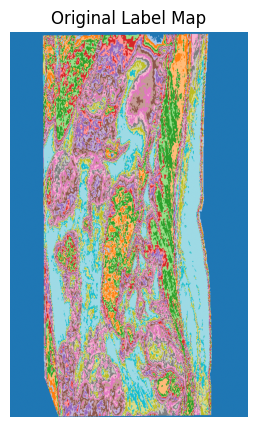

In [12]:
LABEL_PATH = "../example.png"  # 예시, 실제 경로로 수정

label_map = np.array(Image.open(LABEL_PATH)).astype(np.int64)

plt.figure(figsize=(5,5))
plt.title("Original Label Map")
plt.imshow(label_map, cmap="tab20")
plt.axis("off")

gen = SpineSynthGenerator()

In [13]:
print(np.unique(label_map))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [15]:
from sklearn.cluster import KMeans
import numpy as np

H, W = label_map.shape
flat = label_map.reshape(-1, 1)  # grayscale이므로 채널은 1

kmeans = KMeans(n_clusters=4, random_state=0).fit(flat)

labels = kmeans.labels_.reshape(H, W)


In [ ]:
!pip

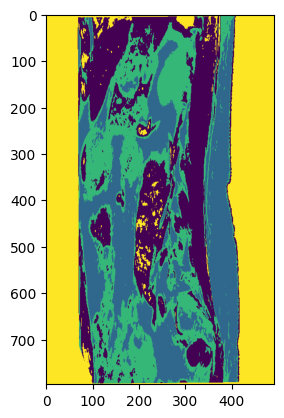

In [ ]:
import nibabel as nib
import numpy as np

nii = nib.load("label_map.nii.gz")
label_map = nii.get_fdata().astype(np.int32)

plt.imshow(labels)

#### 여기서부터 데이터 증강

(np.float64(-0.5), np.float64(491.5), np.float64(796.5), np.float64(-0.5))

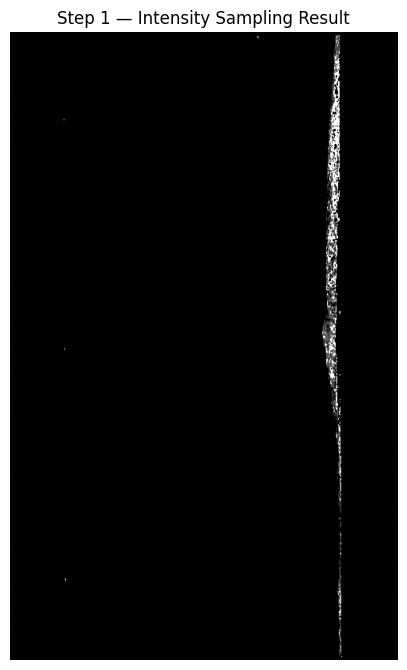

In [6]:
sample_intensity = gen.sample_intensity(label_map)

plt.figure(figsize=(5,10))
plt.title("Step 1 — Intensity Sampling Result")
plt.imshow(sample_intensity, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(491.5), np.float64(796.5), np.float64(-0.5))

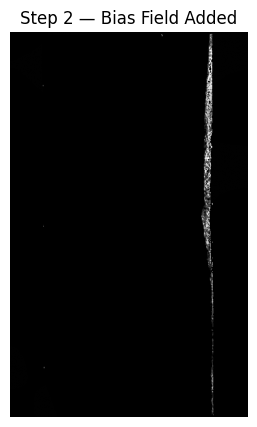

In [7]:
bias_img = gen.add_bias_field(sample_intensity)

plt.figure(figsize=(5,5))
plt.title("Step 2 — Bias Field Added")
plt.imshow(bias_img, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(491.5), np.float64(796.5), np.float64(-0.5))

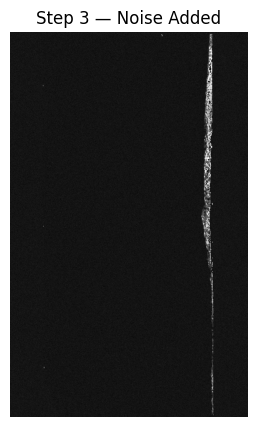

In [8]:
noisy_img = gen.add_noise(bias_img)

plt.figure(figsize=(5,5))
plt.title("Step 3 — Noise Added")
plt.imshow(noisy_img, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(491.5), np.float64(797.5), np.float64(-0.5))

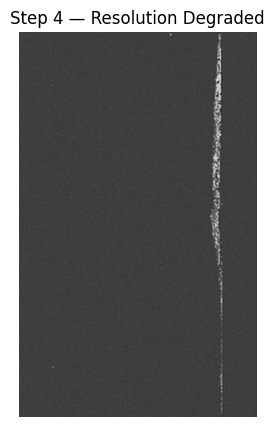

In [9]:
down_img = gen.downsample(noisy_img, factor=2.5)

plt.figure(figsize=(5,5))
plt.title("Step 4 — Resolution Degraded")
plt.imshow(down_img, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(491.5), np.float64(796.5), np.float64(-0.5))

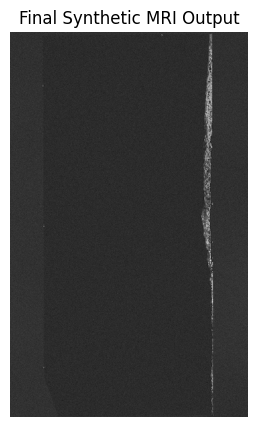

In [10]:
final_img = gen.generate_synthetic_mri(label_map)

plt.figure(figsize=(5,5))
plt.title("Final Synthetic MRI Output")
plt.imshow(final_img, cmap="gray")
plt.axis("off")

#### 저장

In [ ]:
os.makedirs("../data/SYNTH_MRI/", exist_ok=True)
save_path = "../data/SYNTH_MRI/synth_sample.png"

Image.fromarray((final_img / final_img.max() * 255).astype(np.uint8)).save(save_path)
print("Saved:", save_path)